In [1]:
import ember
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier

emberData = "C:\\Users\\cosbyd\\OneDrive - purdue.edu\\Documents\\ember2018"

In [2]:
#create the train/test split (change PATH to where teh ember2018 file is stored tho)
#returns 4 np array (x/y  train and x/y test)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(emberData)

In [3]:
#filter out any data that has a label of -1. These are the files that aren't classified where 0/1 is using to say if its either benign or malware
train_rows = (y_train != -1)
X = X_train[train_rows]
Y = y_train[train_rows]

#Normalize data between 0-1 for better output
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

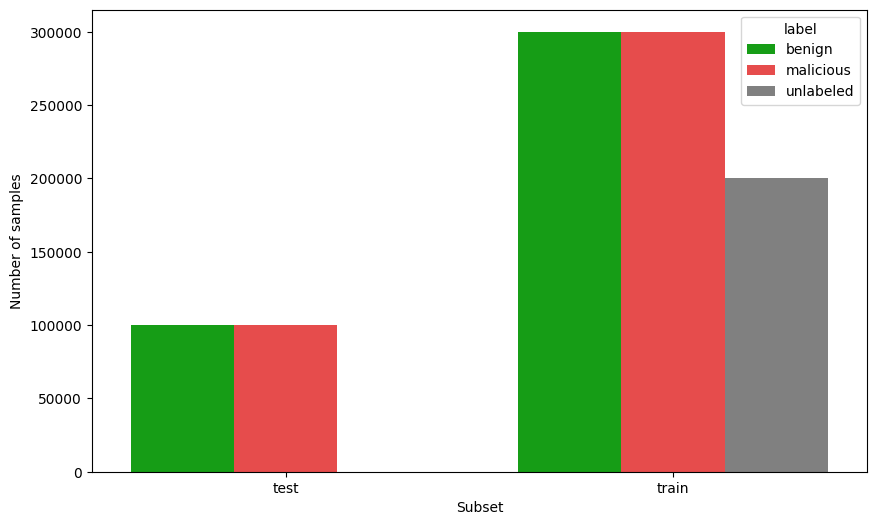

In [4]:
emberdf = ember.read_metadata(emberData)
plotdf = emberdf.copy()
plotdf['label'] = plotdf['label'].map({-1: 'unlabeled', 0: 'benign', 1: 'malicious'})
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='subset', y='sha256', hue='label', data=gbdf, palette=["#00b300", "#ff3333", "#808080"])
plt.xlabel('Subset')
plt.ylabel('Number of samples')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)


# Define the model
model = RandomForestClassifier(n_estimators=300, 
                               max_depth=20, 
                               min_samples_split=2, 
                               min_samples_leaf=2, 
                               max_features='sqrt', 
                               random_state=0)

# Train the model
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=300, random_state=0)

In [6]:
from joblib import dump

# save the model to disk
filename = 'RFModel.joblib'
dump(model, filename)

['RFModel.joblib']

#### Analysis of Model

In [7]:
from tensorflow.keras.models import load_model
import numpy as np
from keras.models import load_model
import ember
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [8]:
# Use the model to make predictions on the validation data
Y_val_pred = model.predict(X_val)

# Compute the accuracy of the model on the validation data
accuracy = accuracy_score(Y_val, Y_val_pred)
print('Validation Accuracy:', accuracy)

Validation Accuracy: 0.9592666666666667


[[95311  4689]
 [35133 64867]]
[[0.95311 0.04689]
 [0.35133 0.64867]]


Text(95.72222222222221, 0.5, 'Truth')

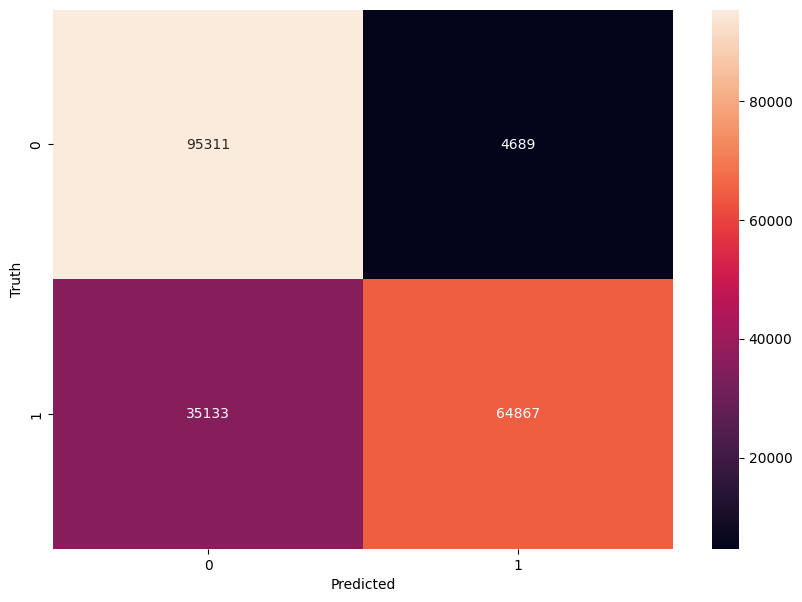

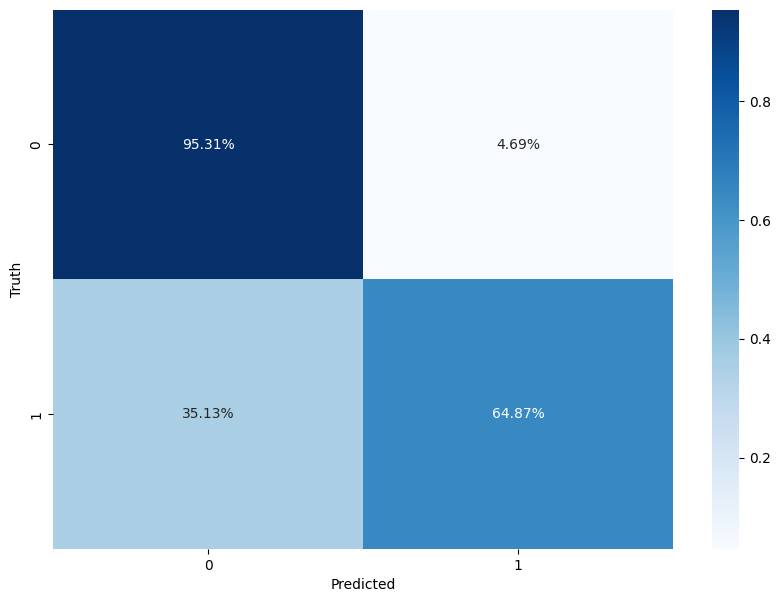

In [11]:
from joblib import load

# load the model from disk
model = load(filename)

y_pred = model.predict(X_test_scaled).ravel()

cm = confusion_matrix(y_test, y_pred.round())
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [13]:
cm = confusion_matrix(y_test, y_pred.round())

TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

True Positives: 64867
False Positives: 4689
True Negatives: 95311
False Negatives: 35133


In [15]:
from sklearn.metrics import classification_report

# Assuming y_true are your true labels and y_pred are the predicted labels
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.95      0.83    100000
         1.0       0.93      0.65      0.77    100000

    accuracy                           0.80    200000
   macro avg       0.83      0.80      0.80    200000
weighted avg       0.83      0.80      0.80    200000



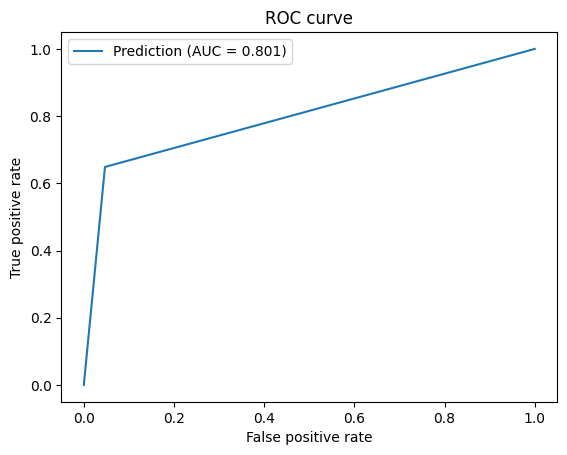

In [10]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = auc(fpr,tpr)

line = plt.plot(fpr, tpr, label='Prediction (AUC = {:.3f})'.format(auc))
yvalues = line[0].get_ydata()
xvalues = line[0].get_xdata()
idx = np.abs(xvalues - 0.01).argmin()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()